<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/MonkeyPFCSaccadeStudies/blob/master/StudyLocationRule/Analysis/04_analyze_target_CNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IMonkeyPFCSaccadeStudies/blob/master/StudyLocationRule/Analysis/04_analyze_target_CNN.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Decode Intended Saccade Direction from Macaque PFC Microelectrode Recordings With Convolutional Neural Networks - Using Spiketrains

## Setup

### Environment Setup
Run the cells in this section to configure the local or Google Colab environments.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys

try:
    from google.colab import files
    %tensorflow_version 2.x  # Only on colab
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
    
    !pip install git+https://github.com/SachsLab/indl.git
    
    if Path.cwd().stem == 'MonkeyPFCSaccadeStudies':
        os.chdir(Path.cwd().parent)

    if not (Path.cwd() / 'MonkeyPFCSaccadeStudies').is_dir():
        !git clone --single-branch --recursive https://github.com/SachsLab/MonkeyPFCSaccadeStudies.git
        sys.path.append(str(Path.cwd() / 'MonkeyPFCSaccadeStudies'))
    os.chdir('MonkeyPFCSaccadeStudies')
    
    !pip install -q kaggle
    !pip install -U scikit-learn
    IN_COLAB = True
except ModuleNotFoundError:
    import sys
    
    # chdir to MonkeyPFCSaccadeStudies
    if Path.cwd().stem == 'Analysis':
        os.chdir(Path.cwd().parent.parent)
    
    # Add indl repository to path.
    # Eventually this should already be pip installed, but it's still under heavy development so this is easier for now.
    check_dir = Path.cwd()
    while not (check_dir / 'Tools').is_dir():
        check_dir = check_dir / '..'
    indl_path = check_dir / 'Tools' / 'Neurophys' / 'indl'
    sys.path.append(str(indl_path))
    
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    
    IN_COLAB = False

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
# Additional imports
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from indl.display import turbo_cmap

In [4]:
# Configure plotting defaults.
if IN_COLAB:
    plt.style.use('dark_background')
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

### Download data if necessary

In [5]:
if IN_COLAB:
    data_path = Path.cwd() / 'data' / 'monkey_pfc' / 'converted'
else:
    data_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed'

if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


### Prepare to load data

We will use a custom function load_macaque_pfc to load the data into memory.

There are 4 different strings to be passed to the import x_chunk argument:
* 'analogsignals' - if present. Returns 1 kHz LFPs
* 'gaze' - Returns 2-channel gaze data.
* 'spikerates' - Returns smoothed spikerates
* 'spiketrains'

The y_type argument can be
* 'pair and choice' - returns Y as np.array of (target_pair, choice_within_pair)
* 'encoded input' - returns Y as np.array of shape (n_samples, 10) (explained below)
* 'replace with column name' - returns Y as a vector of per-trial values. e.g., 'sacClass'

The actual data we load depends on the particular analysis.

In [6]:
from misc.misc import load_macaque_pfc, sess_infos

load_kwargs = {
    'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': False,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': True,
    'y_type': 'sacClass',  # Integer 0:7 for 8 different targets.
    'samples_last': True  # Our EEGNet blocks expect time-samples in the last dimension.
}

## Decoding trial class (0:7) from spike rates

### Load Data

Load the per-trial spikerates and saccadeClass (0:7)

In [7]:
# SESS_ID = ['sra3_1_j_050_00', 'sra3_1_m_074_0001']
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spiketrains', **load_kwargs)


Importing session sra3_1_j_051_00+
Found 271 trials, 1700 timestamps(-0.25 to 1.449 at 1000.0 Hz), 32 channels
Returning Y as sacClass with shape (271, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])


### Create Model

Our model objective is to transform timeseries segments into probabilities of each class.

Let's start with a function to make the model:

In [35]:
from indl.model import parts
from indl.model.helper import check_inputs
from indl.regularizers import KernelLengthRegularizer
from tensorflow.keras import layers


# spike times are binned to nearest msec.
# If we assume the first layer can learn to convert spike times to spike rates,
# how long should we allow the kernel to get? 50 msec? 100 msec? 200 msec?
SPIKE2RATEKERN = 300
NSPIKE2RATE = 1


@check_inputs
def make_model(
        _input,
        n_spiketrain_kerns=4, # Theoretically can learn to demultiplex busts and solitary events.
        spiketrain_pooling=10,
        F1=8, kernLength=25, F1_kern_reg=None,
        D=2, D_pooling=4,
        F2=8, F2_kernLength=16,
        F2_pooling=8,
        dropoutRate=0.25,
        activation='relu',
        l1_reg=0.000, l2_reg=0.000,
        norm_rate=0.25,
        latent_dim=16,
        return_model=True
    ):
    input_shape = _input.shape.as_list()
    # Usually the filter dimension does not exist so let's add that.
    if len(input_shape) < 4:
        input_shape = input_shape + [1]
#     input_shape[2] = -1
    _y = layers.Reshape(input_shape[1:])(_input)
    
    # Spiketimes to something smooth and rate like?
    if True:
        rate_kern_regu = None  # tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
    else:
        rate_kern_regu = KernelLengthRegularizer((1, SPIKE2RATEKERN),
                                                  window_scale=1e-5,
                                                  window_func='poly',
                                                  poly_exp=2,
                                                  threshold=0.00015)
    _y = layers.Conv2D(n_spiketrain_kerns, (SPIKE2RATEKERN, 1),
                       padding='same',
                       trainable=True,
#                        kernel_regularizer=rate_kern_regu,
                       name='train2rate'
                       )(_y)
    _y = layers.Activation(activation)(_y)
    # 1 khz to 100 Hz, same as rates.
    _y = layers.AveragePooling2D(pool_size=(1, spiketrain_pooling*2),
                                 strides=(1, 1),
                                 padding='same'
                                 )(_y)
    _y = layers.MaxPooling2D(pool_size=(1, spiketrain_pooling))(_y)
    _y = layers.BatchNormalization()(_y)
    
    # EEGNetEnc
    if F1_kern_reg is None:
        F1_kern_reg = tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
    elif isinstance(F1_kern_reg, str) and F1_kern_reg == 'kern_length_regu':
        F1_kern_reg = KernelLengthRegularizer((1, kernLength),
                                              window_scale=1e-4,
                                              window_func='poly',
                                              poly_exp=2,
                                              threshold=0.0015)
    _y = parts.EEGNetEnc(_y,
                         F1=F1,
                         F1_kernLength=kernLength,
                         F1_kern_reg=F1_kern_reg,
                         D=D,
                         D_pooling=D_pooling,
                         F2=F2,
                         F2_pooling=F2_pooling,
                         F2_kernLength=F2_kernLength,
                         dropoutRate=dropoutRate)
    
    # Restore time-dimension that was stripped out by EEGNetEnc
    _y = layers.Reshape((1, _input.shape.as_list()[2] // spiketrain_pooling // D_pooling // F2_pooling, F2))(_y)
    
    # Dense
    _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    _y = parts.Classify(_y, n_classes=8, norm_rate=norm_rate)
    
    if return_model:
        return tf.keras.models.Model(inputs=[_input], outputs=[_y])
    else:
        return _y

In [36]:
from indl.misc.kernels import Alpha

def get_kernel(kern_length, kernel_param=0.03, srate=1000):
    span_fac = 6.0  # How many stdevs wide the kernel should be. Too short will truncate kernel.
    t_kern = np.arange(-span_fac * kernel_param, span_fac * kernel_param + (1 / srate), 1 / srate)
    kernel = Alpha(t_kern, kernel_param*np.sqrt(2))
    if len(kernel) > kern_length:
        trim = len(kernel) - kern_length
        return kernel[trim // 2: trim // 2 + kern_length]
    else:
        output = np.zeros((kern_length,))
        shortfall = kern_length - len(kernel)
        output[shortfall // 2 : shortfall // 2 + len(kernel)] = kernel
        return output

kerns = []
for kw in (0.03, 0.06, 0.1)[:NSPIKE2RATE]:
    _kern = get_kernel(SPIKE2RATEKERN, kernel_param=kw)
    _kern /= np.sum(_kern)
    kerns.append(_kern)
kerns = np.reshape(kerns, (SPIKE2RATEKERN, 1, 1, NSPIKE2RATE))

Parameterize the model and preview the model.
 

In [40]:
model_kwargs = dict(
    n_spiketrain_kerns=NSPIKE2RATE, # Theoretically can learn to demultiplex busts and solitary events.
    spiketrain_pooling=10,
    F1=8, kernLength=25, F1_kern_reg=None,
    D=2, D_pooling=4,
    F2=8, F2_kernLength=16,
    F2_pooling=8,
    dropoutRate=0.30,
    activation='relu',
    l1_reg=0.000, l2_reg=0.003,
    norm_rate=0.25,
    latent_dim=16
)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(
    tf.data.Dataset.from_tensor_slices(X_rates).batch(16, drop_remainder=True).element_spec,
    **model_kwargs
)

model.get_layer('train2rate').set_weights((kerns, np.zeros((model_kwargs['n_spiketrain_kerns'],))))

optim = tf.keras.optimizers.Nadam(learning_rate=0.0005)
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
if False:
    tf.keras.utils.plot_model(
        model,
        to_file='model.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96
    )


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 1700)]        0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 1700, 1)       0         
_________________________________________________________________
train2rate (Conv2D)          (None, 32, 1700, 1)       301       
_________________________________________________________________
activation (Activation)      (None, 32, 1700, 1)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 1700, 1)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 170, 1)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 170, 1)        4     

### Training loop


In [41]:
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
BATCH_SIZE = 16
EPOCHS = 180


def get_hists_acc(sess_id, verbose=1):
    print(f"Processing session {sess_id}...")
    X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spiketrains', **load_kwargs)
    X_rates = X_rates.astype(np.float32)
    
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], Y_class[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], Y_class[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)

        model = make_model(
            ds_train.element_spec[0],
            **model_kwargs
        )
        model.get_layer('train2rate').set_weights((kerns, np.zeros((model_kwargs['n_spiketrain_kerns'],))))
        model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        best_model_path = f'spktr2class_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"Session {sess_id} overall accuracy: {accuracy}%")
    
    return history, accuracy
        

Test training on one session.

Processing session sra3_1_j_051_00+...
Found 271 trials, 1700 timestamps(-0.25 to 1.449 at 1000.0 Hz), 32 channels
Returning Y as sacClass with shape (271, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
	Split 1 of 10
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.27586, saving model to spktr2class_sra3_1_j_051_00+_split0.h5
15/15 - 3s - loss: 2.0099 - accuracy: 0.2792 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/180

Epoch 00002: val_accuracy did not improve from 0.27586
15/15 - 1s - loss: 1.7221 - accuracy: 0.4875 - val_loss: 2.0593 - val_accuracy: 0.2759
Epoch 3/180

Epoch 00003: val_accuracy did not improve from 0.27586
15/15 - 1s - loss: 1.4674 - accuracy: 0.5542 - val_loss: 2.0407 - val_accuracy: 0.2759
Epoch 4/180

Epoch 00004: val_accuracy did not improve from 0.27586
15/15 - 1s - loss: 1.2681 - accuracy: 0.6083 - val_loss: 2.0188 - val_accuracy: 0.2759
Epoch 5/180

Epoch 00005:

Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.5440 - accuracy: 0.7750 - val_loss: 0.8569 - val_accuracy: 0.6552
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.5491 - accuracy: 0.7875 - val_loss: 0.7876 - val_accuracy: 0.6552
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.5642 - accuracy: 0.7875 - val_loss: 0.9173 - val_accuracy: 0.6207
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.5522 - accuracy: 0.7708 - val_loss: 1.4234 - val_accuracy: 0.4828
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.5077 - accuracy: 0.8208 - val_loss: 0.5517 - val_accuracy: 0.6897
Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.5032 - accuracy: 0.8125 - val_loss: 0.5881 - val_accuracy: 0.7241
Epoch 56/180

Epoch 00056: val_accuracy did not improve from 0.7

Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.3659 - accuracy: 0.8625 - val_loss: 0.5895 - val_accuracy: 0.6552
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.3147 - accuracy: 0.8917 - val_loss: 0.7911 - val_accuracy: 0.6552
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.2974 - accuracy: 0.9042 - val_loss: 0.6368 - val_accuracy: 0.6897
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.3340 - accuracy: 0.8708 - val_loss: 0.5427 - val_accuracy: 0.6897
Epoch 107/180

Epoch 00107: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.3772 - accuracy: 0.8583 - val_loss: 0.5700 - val_accuracy: 0.7586
Epoch 108/180

Epoch 00108: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.3482 - accuracy: 0.8667 - val_loss: 0.5834 - val_accuracy: 0.6897
Epoch 109/180

Epoch 00109: val_accuracy did not improve f

Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.2947 - accuracy: 0.8875 - val_loss: 0.7913 - val_accuracy: 0.7241
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.2466 - accuracy: 0.9375 - val_loss: 0.6011 - val_accuracy: 0.7586
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.2788 - accuracy: 0.8917 - val_loss: 0.5859 - val_accuracy: 0.7586
Epoch 159/180

Epoch 00159: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.2769 - accuracy: 0.9083 - val_loss: 0.7774 - val_accuracy: 0.6552
Epoch 160/180

Epoch 00160: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.3180 - accuracy: 0.8958 - val_loss: 1.0530 - val_accuracy: 0.6207
Epoch 161/180

Epoch 00161: val_accuracy did not improve from 0.79310
15/15 - 1s - loss: 0.2554 - accuracy: 0.9167 - val_loss: 0.7560 - val_accuracy: 0.6207
Epoch 162/180

Epoch 00162: val_accuracy did not improve f

Epoch 28/180

Epoch 00028: val_accuracy did not improve from 0.32143
15/15 - 1s - loss: 0.6736 - accuracy: 0.7167 - val_loss: 1.8936 - val_accuracy: 0.0714
Epoch 29/180

Epoch 00029: val_accuracy did not improve from 0.32143
15/15 - 1s - loss: 0.6701 - accuracy: 0.7167 - val_loss: 1.9504 - val_accuracy: 0.0714
Epoch 30/180

Epoch 00030: val_accuracy did not improve from 0.32143
15/15 - 1s - loss: 0.6857 - accuracy: 0.7042 - val_loss: 1.9106 - val_accuracy: 0.0714
Epoch 31/180

Epoch 00031: val_accuracy did not improve from 0.32143
15/15 - 1s - loss: 0.6957 - accuracy: 0.7125 - val_loss: 1.7713 - val_accuracy: 0.1786
Epoch 32/180

Epoch 00032: val_accuracy improved from 0.32143 to 0.39286, saving model to spktr2class_sra3_1_j_051_00+_split1.h5
15/15 - 1s - loss: 0.6727 - accuracy: 0.6792 - val_loss: 1.6167 - val_accuracy: 0.3929
Epoch 33/180

Epoch 00033: val_accuracy did not improve from 0.39286
15/15 - 1s - loss: 0.6613 - accuracy: 0.7333 - val_loss: 1.6332 - val_accuracy: 0.3214
Epoc

Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.4231 - accuracy: 0.8292 - val_loss: 0.3683 - val_accuracy: 0.8929
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.4086 - accuracy: 0.8417 - val_loss: 0.4271 - val_accuracy: 0.7857
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.4265 - accuracy: 0.8417 - val_loss: 0.7292 - val_accuracy: 0.6786
Epoch 81/180

Epoch 00081: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.4334 - accuracy: 0.8250 - val_loss: 0.4430 - val_accuracy: 0.8214
Epoch 82/180

Epoch 00082: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.4629 - accuracy: 0.8250 - val_loss: 0.3870 - val_accuracy: 0.8571
Epoch 83/180

Epoch 00083: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.4093 - accuracy: 0.8375 - val_loss: 1.2059 - val_accuracy: 0.6429
Epoch 84/180

Epoch 00084: val_accuracy did not improve from 0.8

Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.3096 - accuracy: 0.8750 - val_loss: 0.3477 - val_accuracy: 0.8929
Epoch 132/180

Epoch 00132: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.3136 - accuracy: 0.8792 - val_loss: 0.3507 - val_accuracy: 0.8571
Epoch 133/180

Epoch 00133: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.3376 - accuracy: 0.8667 - val_loss: 0.3702 - val_accuracy: 0.8571
Epoch 134/180

Epoch 00134: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.3185 - accuracy: 0.8750 - val_loss: 0.5416 - val_accuracy: 0.8214
Epoch 135/180

Epoch 00135: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.3466 - accuracy: 0.8792 - val_loss: 0.4986 - val_accuracy: 0.8214
Epoch 136/180

Epoch 00136: val_accuracy did not improve from 0.89286
15/15 - 1s - loss: 0.3083 - accuracy: 0.8875 - val_loss: 0.3323 - val_accuracy: 0.8929
Epoch 137/180

Epoch 00137: val_accuracy did not improve f

Epoch 3/180

Epoch 00003: val_accuracy did not improve from 0.27586
15/15 - 1s - loss: 1.4800 - accuracy: 0.5708 - val_loss: 2.0426 - val_accuracy: 0.2759
Epoch 4/180

Epoch 00004: val_accuracy did not improve from 0.27586
15/15 - 1s - loss: 1.2949 - accuracy: 0.6125 - val_loss: 2.0211 - val_accuracy: 0.2759
Epoch 5/180

Epoch 00005: val_accuracy did not improve from 0.27586
15/15 - 1s - loss: 1.1710 - accuracy: 0.6083 - val_loss: 1.9998 - val_accuracy: 0.2759
Epoch 6/180

Epoch 00006: val_accuracy did not improve from 0.27586
15/15 - 1s - loss: 1.0645 - accuracy: 0.6042 - val_loss: 1.9787 - val_accuracy: 0.2759
Epoch 7/180

Epoch 00007: val_accuracy did not improve from 0.27586
15/15 - 1s - loss: 1.0012 - accuracy: 0.5625 - val_loss: 1.9633 - val_accuracy: 0.2759
Epoch 8/180

Epoch 00008: val_accuracy did not improve from 0.27586
15/15 - 1s - loss: 0.9547 - accuracy: 0.5917 - val_loss: 1.9517 - val_accuracy: 0.2759
Epoch 9/180

Epoch 00009: val_accuracy did not improve from 0.27586
15


Epoch 00054: val_accuracy improved from 0.58621 to 0.72414, saving model to spktr2class_sra3_1_j_051_00+_split2.h5
15/15 - 1s - loss: 0.5445 - accuracy: 0.8167 - val_loss: 0.6337 - val_accuracy: 0.7241
Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.5430 - accuracy: 0.7833 - val_loss: 1.5029 - val_accuracy: 0.3448
Epoch 56/180

Epoch 00056: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.5240 - accuracy: 0.7917 - val_loss: 1.7125 - val_accuracy: 0.3448
Epoch 57/180

Epoch 00057: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.5012 - accuracy: 0.8083 - val_loss: 2.6349 - val_accuracy: 0.3448
Epoch 58/180

Epoch 00058: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.4955 - accuracy: 0.8250 - val_loss: 1.5348 - val_accuracy: 0.3448
Epoch 59/180

Epoch 00059: val_accuracy did not improve from 0.72414
15/15 - 1s - loss: 0.5355 - accuracy: 0.8000 - val_loss: 1.2304 - val_accuracy: 0.5172
Epoch 60/180

Epo

Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.3017 - accuracy: 0.9042 - val_loss: 0.6528 - val_accuracy: 0.6897
Epoch 107/180

Epoch 00107: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.3729 - accuracy: 0.8667 - val_loss: 0.5915 - val_accuracy: 0.7586
Epoch 108/180

Epoch 00108: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.3688 - accuracy: 0.8500 - val_loss: 0.5891 - val_accuracy: 0.7241
Epoch 109/180

Epoch 00109: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.3981 - accuracy: 0.8375 - val_loss: 0.5872 - val_accuracy: 0.7586
Epoch 110/180

Epoch 00110: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.3686 - accuracy: 0.8833 - val_loss: 0.7819 - val_accuracy: 0.5862
Epoch 111/180

Epoch 00111: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.3962 - accuracy: 0.8583 - val_loss: 0.8850 - val_accuracy: 0.6207
Epoch 112/180

Epoch 00112: val_accuracy did not improve f

Epoch 159/180

Epoch 00159: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.2271 - accuracy: 0.9125 - val_loss: 0.7874 - val_accuracy: 0.6897
Epoch 160/180

Epoch 00160: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.2447 - accuracy: 0.9375 - val_loss: 0.7495 - val_accuracy: 0.6552
Epoch 161/180

Epoch 00161: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.2485 - accuracy: 0.9167 - val_loss: 0.6422 - val_accuracy: 0.6897
Epoch 162/180

Epoch 00162: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.2961 - accuracy: 0.9000 - val_loss: 0.7181 - val_accuracy: 0.7241
Epoch 163/180

Epoch 00163: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.2343 - accuracy: 0.9042 - val_loss: 2.0592 - val_accuracy: 0.4138
Epoch 164/180

Epoch 00164: val_accuracy did not improve from 0.86207
15/15 - 1s - loss: 0.2674 - accuracy: 0.9000 - val_loss: 0.6492 - val_accuracy: 0.6207
Epoch 165/180

Epoch 00165: val_accuracy did not improve f

Epoch 31/180

Epoch 00031: val_accuracy improved from 0.33333 to 0.66667, saving model to spktr2class_sra3_1_j_051_00+_split3.h5
15/15 - 1s - loss: 0.6715 - accuracy: 0.7042 - val_loss: 1.6157 - val_accuracy: 0.6667
Epoch 32/180

Epoch 00032: val_accuracy improved from 0.66667 to 0.70370, saving model to spktr2class_sra3_1_j_051_00+_split3.h5
15/15 - 1s - loss: 0.6346 - accuracy: 0.7375 - val_loss: 1.4560 - val_accuracy: 0.7037
Epoch 33/180

Epoch 00033: val_accuracy did not improve from 0.70370
15/15 - 1s - loss: 0.6355 - accuracy: 0.7250 - val_loss: 1.3942 - val_accuracy: 0.6667
Epoch 34/180

Epoch 00034: val_accuracy did not improve from 0.70370
15/15 - 1s - loss: 0.6541 - accuracy: 0.7250 - val_loss: 1.2975 - val_accuracy: 0.5926
Epoch 35/180

Epoch 00035: val_accuracy did not improve from 0.70370
15/15 - 1s - loss: 0.6350 - accuracy: 0.7167 - val_loss: 1.3722 - val_accuracy: 0.2963
Epoch 36/180

Epoch 00036: val_accuracy did not improve from 0.70370
15/15 - 1s - loss: 0.6325 - acc

Epoch 83/180

Epoch 00083: val_accuracy did not improve from 0.77778
15/15 - 1s - loss: 0.5110 - accuracy: 0.7667 - val_loss: 1.1049 - val_accuracy: 0.5185
Epoch 84/180

Epoch 00084: val_accuracy did not improve from 0.77778
15/15 - 1s - loss: 0.4710 - accuracy: 0.8042 - val_loss: 1.1969 - val_accuracy: 0.5185
Epoch 85/180

Epoch 00085: val_accuracy did not improve from 0.77778
15/15 - 1s - loss: 0.4284 - accuracy: 0.8250 - val_loss: 0.7248 - val_accuracy: 0.5926
Epoch 86/180

Epoch 00086: val_accuracy did not improve from 0.77778
15/15 - 1s - loss: 0.4026 - accuracy: 0.8375 - val_loss: 0.7171 - val_accuracy: 0.6667
Epoch 87/180

Epoch 00087: val_accuracy did not improve from 0.77778
15/15 - 1s - loss: 0.4624 - accuracy: 0.8167 - val_loss: 0.7435 - val_accuracy: 0.6296
Epoch 88/180

Epoch 00088: val_accuracy did not improve from 0.77778
15/15 - 1s - loss: 0.4122 - accuracy: 0.8292 - val_loss: 1.7953 - val_accuracy: 0.3704
Epoch 89/180

Epoch 00089: val_accuracy did not improve from 0.7

Epoch 135/180

Epoch 00135: val_accuracy did not improve from 0.85185
15/15 - 1s - loss: 0.3784 - accuracy: 0.8708 - val_loss: 0.7893 - val_accuracy: 0.7037
Epoch 136/180

Epoch 00136: val_accuracy did not improve from 0.85185
15/15 - 1s - loss: 0.3697 - accuracy: 0.8875 - val_loss: 1.5538 - val_accuracy: 0.4444
Epoch 137/180

Epoch 00137: val_accuracy did not improve from 0.85185
15/15 - 1s - loss: 0.3961 - accuracy: 0.8458 - val_loss: 3.1060 - val_accuracy: 0.3704
Epoch 138/180

Epoch 00138: val_accuracy did not improve from 0.85185
15/15 - 1s - loss: 0.3042 - accuracy: 0.9208 - val_loss: 4.3125 - val_accuracy: 0.2963
Epoch 139/180

Epoch 00139: val_accuracy did not improve from 0.85185
15/15 - 1s - loss: 0.3170 - accuracy: 0.8750 - val_loss: 6.8924 - val_accuracy: 0.2963
Epoch 140/180

Epoch 00140: val_accuracy did not improve from 0.85185
15/15 - 1s - loss: 0.3002 - accuracy: 0.8792 - val_loss: 2.6491 - val_accuracy: 0.3704
Epoch 141/180

Epoch 00141: val_accuracy did not improve f

Epoch 7/180

Epoch 00007: val_accuracy did not improve from 0.28571
15/15 - 1s - loss: 0.9981 - accuracy: 0.6125 - val_loss: 1.9767 - val_accuracy: 0.2857
Epoch 8/180

Epoch 00008: val_accuracy did not improve from 0.28571
15/15 - 1s - loss: 0.9264 - accuracy: 0.5875 - val_loss: 1.9716 - val_accuracy: 0.2857
Epoch 9/180

Epoch 00009: val_accuracy did not improve from 0.28571
15/15 - 1s - loss: 0.8888 - accuracy: 0.6167 - val_loss: 1.9727 - val_accuracy: 0.2857
Epoch 10/180

Epoch 00010: val_accuracy did not improve from 0.28571
15/15 - 1s - loss: 0.8934 - accuracy: 0.6375 - val_loss: 1.9731 - val_accuracy: 0.2857
Epoch 11/180

Epoch 00011: val_accuracy did not improve from 0.28571
15/15 - 1s - loss: 0.8869 - accuracy: 0.5708 - val_loss: 1.9785 - val_accuracy: 0.2857
Epoch 12/180

Epoch 00012: val_accuracy did not improve from 0.28571
15/15 - 1s - loss: 0.8676 - accuracy: 0.6375 - val_loss: 1.9818 - val_accuracy: 0.2857
Epoch 13/180

Epoch 00013: val_accuracy did not improve from 0.2857

Epoch 57/180

Epoch 00057: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.5264 - accuracy: 0.8042 - val_loss: 0.6867 - val_accuracy: 0.7143
Epoch 58/180

Epoch 00058: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.5295 - accuracy: 0.8083 - val_loss: 0.5205 - val_accuracy: 0.7500
Epoch 59/180

Epoch 00059: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.5144 - accuracy: 0.7875 - val_loss: 1.2307 - val_accuracy: 0.3571
Epoch 60/180

Epoch 00060: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.4877 - accuracy: 0.7917 - val_loss: 1.5142 - val_accuracy: 0.3214
Epoch 61/180

Epoch 00061: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.5029 - accuracy: 0.7667 - val_loss: 0.5764 - val_accuracy: 0.7143
Epoch 62/180

Epoch 00062: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.4827 - accuracy: 0.8167 - val_loss: 0.5585 - val_accuracy: 0.7143
Epoch 63/180

Epoch 00063: val_accuracy did not improve from 0.7


Epoch 00109: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.3256 - accuracy: 0.8833 - val_loss: 0.7853 - val_accuracy: 0.7143
Epoch 110/180

Epoch 00110: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.3504 - accuracy: 0.8792 - val_loss: 0.5915 - val_accuracy: 0.7500
Epoch 111/180

Epoch 00111: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.3445 - accuracy: 0.8708 - val_loss: 0.7494 - val_accuracy: 0.7500
Epoch 112/180

Epoch 00112: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.3657 - accuracy: 0.8458 - val_loss: 0.7980 - val_accuracy: 0.6786
Epoch 113/180

Epoch 00113: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.3629 - accuracy: 0.8750 - val_loss: 0.5947 - val_accuracy: 0.7500
Epoch 114/180

Epoch 00114: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.3459 - accuracy: 0.8625 - val_loss: 0.7084 - val_accuracy: 0.6786
Epoch 115/180

Epoch 00115: val_accuracy did not improve from 0.82143
15

Epoch 162/180

Epoch 00162: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.3023 - accuracy: 0.9000 - val_loss: 0.7532 - val_accuracy: 0.7143
Epoch 163/180

Epoch 00163: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.2980 - accuracy: 0.9000 - val_loss: 0.6552 - val_accuracy: 0.6786
Epoch 164/180

Epoch 00164: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.2637 - accuracy: 0.8917 - val_loss: 0.7266 - val_accuracy: 0.6786
Epoch 165/180

Epoch 00165: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.3015 - accuracy: 0.8792 - val_loss: 0.6420 - val_accuracy: 0.6786
Epoch 166/180

Epoch 00166: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.2347 - accuracy: 0.9125 - val_loss: 0.6852 - val_accuracy: 0.6786
Epoch 167/180

Epoch 00167: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.2539 - accuracy: 0.9125 - val_loss: 0.7155 - val_accuracy: 0.7143
Epoch 168/180

Epoch 00168: val_accuracy did not improve f

Epoch 34/180

Epoch 00034: val_accuracy did not improve from 0.60714
15/15 - 1s - loss: 0.6041 - accuracy: 0.7542 - val_loss: 1.2182 - val_accuracy: 0.6071
Epoch 35/180

Epoch 00035: val_accuracy did not improve from 0.60714
15/15 - 1s - loss: 0.6779 - accuracy: 0.7125 - val_loss: 1.2709 - val_accuracy: 0.3214
Epoch 36/180

Epoch 00036: val_accuracy did not improve from 0.60714
15/15 - 1s - loss: 0.6288 - accuracy: 0.7167 - val_loss: 1.4212 - val_accuracy: 0.3214
Epoch 37/180

Epoch 00037: val_accuracy did not improve from 0.60714
15/15 - 1s - loss: 0.6217 - accuracy: 0.7125 - val_loss: 1.2935 - val_accuracy: 0.3214
Epoch 38/180

Epoch 00038: val_accuracy did not improve from 0.60714
15/15 - 1s - loss: 0.5972 - accuracy: 0.7625 - val_loss: 1.2165 - val_accuracy: 0.3214
Epoch 39/180

Epoch 00039: val_accuracy improved from 0.60714 to 0.64286, saving model to spktr2class_sra3_1_j_051_00+_split5.h5
15/15 - 1s - loss: 0.6155 - accuracy: 0.7583 - val_loss: 0.9544 - val_accuracy: 0.6429
Epoc

Epoch 86/180

Epoch 00086: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.3938 - accuracy: 0.8583 - val_loss: 0.8714 - val_accuracy: 0.6429
Epoch 87/180

Epoch 00087: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.4146 - accuracy: 0.8417 - val_loss: 0.8983 - val_accuracy: 0.6429
Epoch 88/180

Epoch 00088: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.4181 - accuracy: 0.8333 - val_loss: 1.2909 - val_accuracy: 0.6429
Epoch 89/180

Epoch 00089: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.4136 - accuracy: 0.8458 - val_loss: 1.3926 - val_accuracy: 0.4643
Epoch 90/180

Epoch 00090: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.4334 - accuracy: 0.8125 - val_loss: 0.7471 - val_accuracy: 0.6429
Epoch 91/180

Epoch 00091: val_accuracy did not improve from 0.78571
15/15 - 1s - loss: 0.4204 - accuracy: 0.8208 - val_loss: 0.8889 - val_accuracy: 0.6429
Epoch 92/180

Epoch 00092: val_accuracy did not improve from 0.7

Epoch 138/180

Epoch 00138: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.3356 - accuracy: 0.8625 - val_loss: 0.6658 - val_accuracy: 0.6786
Epoch 139/180

Epoch 00139: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.2810 - accuracy: 0.8833 - val_loss: 1.0812 - val_accuracy: 0.6786
Epoch 140/180

Epoch 00140: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.2901 - accuracy: 0.9042 - val_loss: 1.2136 - val_accuracy: 0.6786
Epoch 141/180

Epoch 00141: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.2823 - accuracy: 0.8708 - val_loss: 3.3147 - val_accuracy: 0.4643
Epoch 142/180

Epoch 00142: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.2719 - accuracy: 0.9042 - val_loss: 4.3369 - val_accuracy: 0.3214
Epoch 143/180

Epoch 00143: val_accuracy did not improve from 0.82143
15/15 - 1s - loss: 0.2240 - accuracy: 0.9333 - val_loss: 2.1110 - val_accuracy: 0.5000
Epoch 144/180

Epoch 00144: val_accuracy did not improve f

Epoch 10/180

Epoch 00010: val_accuracy did not improve from 0.26923
15/15 - 1s - loss: 0.9135 - accuracy: 0.6167 - val_loss: 1.9207 - val_accuracy: 0.2692
Epoch 11/180

Epoch 00011: val_accuracy did not improve from 0.26923
15/15 - 1s - loss: 0.8738 - accuracy: 0.5875 - val_loss: 1.9217 - val_accuracy: 0.2692
Epoch 12/180

Epoch 00012: val_accuracy did not improve from 0.26923
15/15 - 1s - loss: 0.8976 - accuracy: 0.6208 - val_loss: 1.9209 - val_accuracy: 0.2692
Epoch 13/180

Epoch 00013: val_accuracy did not improve from 0.26923
15/15 - 1s - loss: 0.8571 - accuracy: 0.6083 - val_loss: 1.9270 - val_accuracy: 0.2692
Epoch 14/180

Epoch 00014: val_accuracy did not improve from 0.26923
15/15 - 1s - loss: 0.8488 - accuracy: 0.6500 - val_loss: 1.9294 - val_accuracy: 0.2692
Epoch 15/180

Epoch 00015: val_accuracy did not improve from 0.26923
15/15 - 1s - loss: 0.8417 - accuracy: 0.6250 - val_loss: 1.9419 - val_accuracy: 0.2692
Epoch 16/180

Epoch 00016: val_accuracy did not improve from 0.2

Epoch 61/180

Epoch 00061: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.4975 - accuracy: 0.7875 - val_loss: 1.0842 - val_accuracy: 0.4615
Epoch 62/180

Epoch 00062: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.4703 - accuracy: 0.8375 - val_loss: 0.9628 - val_accuracy: 0.5769
Epoch 63/180

Epoch 00063: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.5148 - accuracy: 0.7958 - val_loss: 1.4751 - val_accuracy: 0.4231
Epoch 64/180

Epoch 00064: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.4790 - accuracy: 0.8000 - val_loss: 0.7925 - val_accuracy: 0.6154
Epoch 65/180

Epoch 00065: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.4840 - accuracy: 0.8292 - val_loss: 1.1262 - val_accuracy: 0.5769
Epoch 66/180

Epoch 00066: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.4688 - accuracy: 0.8375 - val_loss: 1.1789 - val_accuracy: 0.5385
Epoch 67/180

Epoch 00067: val_accuracy did not improve from 0.7

Epoch 114/180

Epoch 00114: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.3383 - accuracy: 0.8833 - val_loss: 1.2846 - val_accuracy: 0.5000
Epoch 115/180

Epoch 00115: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.3469 - accuracy: 0.8958 - val_loss: 1.1338 - val_accuracy: 0.5769
Epoch 116/180

Epoch 00116: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.2982 - accuracy: 0.8708 - val_loss: 0.7578 - val_accuracy: 0.6538
Epoch 117/180

Epoch 00117: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.3080 - accuracy: 0.8875 - val_loss: 0.8889 - val_accuracy: 0.6538
Epoch 118/180

Epoch 00118: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.3113 - accuracy: 0.9042 - val_loss: 1.1088 - val_accuracy: 0.6538
Epoch 119/180

Epoch 00119: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.2988 - accuracy: 0.8917 - val_loss: 0.8338 - val_accuracy: 0.6923
Epoch 120/180

Epoch 00120: val_accuracy did not improve f

Epoch 167/180

Epoch 00167: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.2191 - accuracy: 0.9167 - val_loss: 0.9874 - val_accuracy: 0.5769
Epoch 168/180

Epoch 00168: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.2666 - accuracy: 0.9000 - val_loss: 1.3988 - val_accuracy: 0.6538
Epoch 169/180

Epoch 00169: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.2375 - accuracy: 0.9208 - val_loss: 1.0663 - val_accuracy: 0.5769
Epoch 170/180

Epoch 00170: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.2176 - accuracy: 0.9375 - val_loss: 1.0322 - val_accuracy: 0.5769
Epoch 171/180

Epoch 00171: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.2091 - accuracy: 0.9333 - val_loss: 1.2733 - val_accuracy: 0.5769
Epoch 172/180

Epoch 00172: val_accuracy did not improve from 0.76923
15/15 - 1s - loss: 0.2202 - accuracy: 0.9333 - val_loss: 1.2653 - val_accuracy: 0.5385
Epoch 173/180

Epoch 00173: val_accuracy did not improve f

Epoch 39/180

Epoch 00039: val_accuracy improved from 0.42308 to 0.53846, saving model to spktr2class_sra3_1_j_051_00+_split7.h5
15/15 - 1s - loss: 0.6174 - accuracy: 0.7542 - val_loss: 1.0702 - val_accuracy: 0.5385
Epoch 40/180

Epoch 00040: val_accuracy improved from 0.53846 to 0.57692, saving model to spktr2class_sra3_1_j_051_00+_split7.h5
15/15 - 1s - loss: 0.6150 - accuracy: 0.7208 - val_loss: 1.0423 - val_accuracy: 0.5769
Epoch 41/180

Epoch 00041: val_accuracy improved from 0.57692 to 0.65385, saving model to spktr2class_sra3_1_j_051_00+_split7.h5
15/15 - 1s - loss: 0.5912 - accuracy: 0.7250 - val_loss: 0.9357 - val_accuracy: 0.6538
Epoch 42/180

Epoch 00042: val_accuracy did not improve from 0.65385
15/15 - 1s - loss: 0.5586 - accuracy: 0.7708 - val_loss: 0.9231 - val_accuracy: 0.5769
Epoch 43/180

Epoch 00043: val_accuracy did not improve from 0.65385
15/15 - 1s - loss: 0.5919 - accuracy: 0.7750 - val_loss: 0.9398 - val_accuracy: 0.6154
Epoch 44/180

Epoch 00044: val_accuracy 

Epoch 90/180

Epoch 00090: val_accuracy did not improve from 0.80769
15/15 - 1s - loss: 0.4115 - accuracy: 0.8500 - val_loss: 0.5680 - val_accuracy: 0.7692
Epoch 91/180

Epoch 00091: val_accuracy did not improve from 0.80769
15/15 - 1s - loss: 0.3902 - accuracy: 0.8500 - val_loss: 1.0335 - val_accuracy: 0.5385
Epoch 92/180

Epoch 00092: val_accuracy did not improve from 0.80769
15/15 - 1s - loss: 0.3736 - accuracy: 0.8667 - val_loss: 0.5701 - val_accuracy: 0.7692
Epoch 93/180

Epoch 00093: val_accuracy did not improve from 0.80769
15/15 - 1s - loss: 0.4082 - accuracy: 0.8458 - val_loss: 1.6238 - val_accuracy: 0.4231
Epoch 94/180

Epoch 00094: val_accuracy did not improve from 0.80769
15/15 - 1s - loss: 0.3776 - accuracy: 0.8542 - val_loss: 1.4565 - val_accuracy: 0.4615
Epoch 95/180

Epoch 00095: val_accuracy did not improve from 0.80769
15/15 - 1s - loss: 0.4082 - accuracy: 0.8667 - val_loss: 0.6720 - val_accuracy: 0.6538
Epoch 96/180

Epoch 00096: val_accuracy did not improve from 0.8

Epoch 142/180

Epoch 00142: val_accuracy did not improve from 0.84615
15/15 - 1s - loss: 0.2610 - accuracy: 0.9042 - val_loss: 0.9586 - val_accuracy: 0.5385
Epoch 143/180

Epoch 00143: val_accuracy did not improve from 0.84615
15/15 - 1s - loss: 0.2909 - accuracy: 0.8708 - val_loss: 0.6665 - val_accuracy: 0.7308
Epoch 144/180

Epoch 00144: val_accuracy did not improve from 0.84615
15/15 - 1s - loss: 0.2628 - accuracy: 0.9083 - val_loss: 0.7199 - val_accuracy: 0.7308
Epoch 145/180

Epoch 00145: val_accuracy did not improve from 0.84615
15/15 - 1s - loss: 0.2616 - accuracy: 0.9167 - val_loss: 0.8362 - val_accuracy: 0.6538
Epoch 146/180

Epoch 00146: val_accuracy did not improve from 0.84615
15/15 - 1s - loss: 0.2393 - accuracy: 0.9083 - val_loss: 0.9449 - val_accuracy: 0.6154
Epoch 147/180

Epoch 00147: val_accuracy did not improve from 0.84615
15/15 - 1s - loss: 0.2666 - accuracy: 0.9333 - val_loss: 0.7334 - val_accuracy: 0.8077
Epoch 148/180

Epoch 00148: val_accuracy did not improve f

Epoch 14/180

Epoch 00014: val_accuracy did not improve from 0.28000
15/15 - 1s - loss: 0.8224 - accuracy: 0.6000 - val_loss: 1.9135 - val_accuracy: 0.2800
Epoch 15/180

Epoch 00015: val_accuracy did not improve from 0.28000
15/15 - 1s - loss: 0.7855 - accuracy: 0.5875 - val_loss: 1.9164 - val_accuracy: 0.2800
Epoch 16/180

Epoch 00016: val_accuracy did not improve from 0.28000
15/15 - 1s - loss: 0.8284 - accuracy: 0.5542 - val_loss: 1.9233 - val_accuracy: 0.2800
Epoch 17/180

Epoch 00017: val_accuracy did not improve from 0.28000
15/15 - 1s - loss: 0.8192 - accuracy: 0.6042 - val_loss: 1.9309 - val_accuracy: 0.2800
Epoch 18/180

Epoch 00018: val_accuracy did not improve from 0.28000
15/15 - 1s - loss: 0.8074 - accuracy: 0.6333 - val_loss: 1.9496 - val_accuracy: 0.2800
Epoch 19/180

Epoch 00019: val_accuracy did not improve from 0.28000
15/15 - 1s - loss: 0.7874 - accuracy: 0.6167 - val_loss: 1.9468 - val_accuracy: 0.2800
Epoch 20/180

Epoch 00020: val_accuracy did not improve from 0.2

Epoch 65/180

Epoch 00065: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.5321 - accuracy: 0.7875 - val_loss: 0.4292 - val_accuracy: 0.8400
Epoch 66/180

Epoch 00066: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.5455 - accuracy: 0.7750 - val_loss: 0.5859 - val_accuracy: 0.7200
Epoch 67/180

Epoch 00067: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.4838 - accuracy: 0.8083 - val_loss: 0.4988 - val_accuracy: 0.8400
Epoch 68/180

Epoch 00068: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.4985 - accuracy: 0.8125 - val_loss: 0.4287 - val_accuracy: 0.8400
Epoch 69/180

Epoch 00069: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.5396 - accuracy: 0.7917 - val_loss: 0.3828 - val_accuracy: 0.8800
Epoch 70/180

Epoch 00070: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.4828 - accuracy: 0.8000 - val_loss: 0.3960 - val_accuracy: 0.8800
Epoch 71/180

Epoch 00071: val_accuracy did not improve from 0.8

Epoch 118/180

Epoch 00118: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.3383 - accuracy: 0.9083 - val_loss: 0.4057 - val_accuracy: 0.7600
Epoch 119/180

Epoch 00119: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.3905 - accuracy: 0.8458 - val_loss: 0.4063 - val_accuracy: 0.8000
Epoch 120/180

Epoch 00120: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.2734 - accuracy: 0.9083 - val_loss: 0.3999 - val_accuracy: 0.7600
Epoch 121/180

Epoch 00121: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.3286 - accuracy: 0.8625 - val_loss: 0.4445 - val_accuracy: 0.7200
Epoch 122/180

Epoch 00122: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.3320 - accuracy: 0.9083 - val_loss: 0.8275 - val_accuracy: 0.7600
Epoch 123/180

Epoch 00123: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.2985 - accuracy: 0.8917 - val_loss: 0.3651 - val_accuracy: 0.8400
Epoch 124/180

Epoch 00124: val_accuracy improved from 0.8

Epoch 170/180

Epoch 00170: val_accuracy did not improve from 0.92000
15/15 - 1s - loss: 0.2463 - accuracy: 0.9125 - val_loss: 0.4177 - val_accuracy: 0.7600
Epoch 171/180

Epoch 00171: val_accuracy did not improve from 0.92000
15/15 - 1s - loss: 0.2443 - accuracy: 0.8792 - val_loss: 0.6192 - val_accuracy: 0.7200
Epoch 172/180

Epoch 00172: val_accuracy did not improve from 0.92000
15/15 - 1s - loss: 0.2298 - accuracy: 0.9125 - val_loss: 0.4503 - val_accuracy: 0.8400
Epoch 173/180

Epoch 00173: val_accuracy did not improve from 0.92000
15/15 - 1s - loss: 0.2836 - accuracy: 0.8875 - val_loss: 0.5274 - val_accuracy: 0.8000
Epoch 174/180

Epoch 00174: val_accuracy did not improve from 0.92000
15/15 - 1s - loss: 0.2408 - accuracy: 0.9125 - val_loss: 0.5616 - val_accuracy: 0.6800
Epoch 175/180

Epoch 00175: val_accuracy did not improve from 0.92000
15/15 - 1s - loss: 0.2627 - accuracy: 0.8917 - val_loss: 0.6468 - val_accuracy: 0.8400
Epoch 176/180

Epoch 00176: val_accuracy did not improve f

Epoch 41/180

Epoch 00041: val_accuracy did not improve from 0.40000
15/15 - 1s - loss: 0.5996 - accuracy: 0.7458 - val_loss: 3.8603 - val_accuracy: 0.3200
Epoch 42/180

Epoch 00042: val_accuracy did not improve from 0.40000
15/15 - 1s - loss: 0.6032 - accuracy: 0.7792 - val_loss: 3.8232 - val_accuracy: 0.3200
Epoch 43/180

Epoch 00043: val_accuracy did not improve from 0.40000
15/15 - 1s - loss: 0.5925 - accuracy: 0.7583 - val_loss: 4.8238 - val_accuracy: 0.3200
Epoch 44/180

Epoch 00044: val_accuracy did not improve from 0.40000
15/15 - 1s - loss: 0.5754 - accuracy: 0.7542 - val_loss: 6.4895 - val_accuracy: 0.3200
Epoch 45/180

Epoch 00045: val_accuracy did not improve from 0.40000
15/15 - 1s - loss: 0.5873 - accuracy: 0.7667 - val_loss: 5.9617 - val_accuracy: 0.3200
Epoch 46/180

Epoch 00046: val_accuracy did not improve from 0.40000
15/15 - 1s - loss: 0.5578 - accuracy: 0.7875 - val_loss: 5.1614 - val_accuracy: 0.3200
Epoch 47/180

Epoch 00047: val_accuracy did not improve from 0.4

Epoch 93/180

Epoch 00093: val_accuracy did not improve from 0.76000
15/15 - 1s - loss: 0.3589 - accuracy: 0.8500 - val_loss: 1.1582 - val_accuracy: 0.5200
Epoch 94/180

Epoch 00094: val_accuracy did not improve from 0.76000
15/15 - 1s - loss: 0.4136 - accuracy: 0.8417 - val_loss: 1.5667 - val_accuracy: 0.4000
Epoch 95/180

Epoch 00095: val_accuracy did not improve from 0.76000
15/15 - 1s - loss: 0.3986 - accuracy: 0.8375 - val_loss: 3.3818 - val_accuracy: 0.3600
Epoch 96/180

Epoch 00096: val_accuracy did not improve from 0.76000
15/15 - 1s - loss: 0.3855 - accuracy: 0.8708 - val_loss: 4.0127 - val_accuracy: 0.3600
Epoch 97/180

Epoch 00097: val_accuracy did not improve from 0.76000
15/15 - 1s - loss: 0.3857 - accuracy: 0.8458 - val_loss: 8.4222 - val_accuracy: 0.3200
Epoch 98/180

Epoch 00098: val_accuracy did not improve from 0.76000
15/15 - 1s - loss: 0.4151 - accuracy: 0.8250 - val_loss: 4.0016 - val_accuracy: 0.3600
Epoch 99/180

Epoch 00099: val_accuracy did not improve from 0.7

Epoch 145/180

Epoch 00145: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.2957 - accuracy: 0.8875 - val_loss: 5.4758 - val_accuracy: 0.3600
Epoch 146/180

Epoch 00146: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.2494 - accuracy: 0.9125 - val_loss: 6.4473 - val_accuracy: 0.3600
Epoch 147/180

Epoch 00147: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.3072 - accuracy: 0.9000 - val_loss: 7.4072 - val_accuracy: 0.3600
Epoch 148/180

Epoch 00148: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.2884 - accuracy: 0.9000 - val_loss: 4.3270 - val_accuracy: 0.3600
Epoch 149/180

Epoch 00149: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.2228 - accuracy: 0.9167 - val_loss: 3.4716 - val_accuracy: 0.4000
Epoch 150/180

Epoch 00150: val_accuracy did not improve from 0.88000
15/15 - 1s - loss: 0.2751 - accuracy: 0.9083 - val_loss: 0.5567 - val_accuracy: 0.8000
Epoch 151/180

Epoch 00151: val_accuracy did not improve f

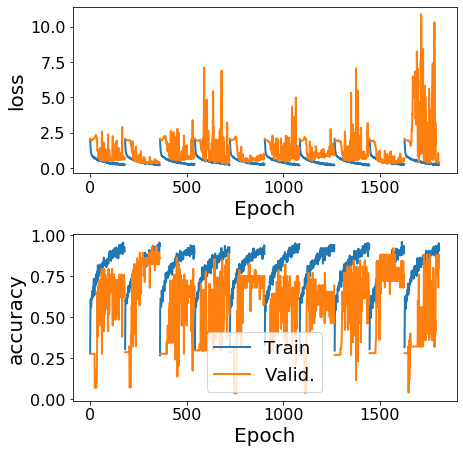

In [42]:
from indl.metrics import quickplot_history

history, accuracy = get_hists_acc(sess_infos[2]['exp_code'], verbose=2)
quickplot_history(history)

### Training and evaluation - per session

Note that using verbose=0 will suppress most of the log information. Progress indicators might only be updated once every few minutes, depending on the number of epochs and the amount of time it takes to process a session.

In [ ]:
hists = []
accs = []
for sess_info in sess_infos:
    _hist, _acc = get_hists_acc(sess_info['exp_code'], verbose=0)
    hists.append(_hist)
    accs.append(_acc)
    
print(accs)

Found 160 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (160, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
Session sra3_2_j_037_00+03 overall accuracy: 65.0%
Found 59 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (59, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])


## TODO
   
1. Use Capsules
1. Replace deeper conv layers with LSTM
1. If using autoencoder, make sure AE on its own can reconstruct input reasonably well.
1. Better model inspection (put code in indl)


Our goal is for the deep model to do at least as well as logistic regression, which gave cross-validated classification accuracies of ~60% and ~81% in two datasets. Using the EEGNet CNN, we achieve 74% and 85%. The improvement on the first dataset improves classification above the unofficial threshold for acceptable BCI performance.

We expect the deep model will be useful in other ways too.

## Inspecting the model

We're doing a little better than we did with logistic regression,
but let's see what we can learn from/about the model.

[Further info](http://cs231n.github.io/understanding-cnn/)



In [ ]:
# Load the 'best' model from disk.
tf.keras.backend.clear_session()
from tensorflow.keras.models import load_model
model = load_model(datadir / 'models' / (SESS_ID + '_model_best_all.h5'))
# model.summary()

### t-Distributed Stochastic Neighbour Embedding (t-SNE)

https://distill.pub/2016/misread-tsne/

From [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

>t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

We will compare the t-SNE projections of the outputs to the projections of the inputs.
However, the raw spiketrains do not decompose to very well so for inputs we will use spikerates that are previously derived from the spike trains convolved with a gaussian kernel (sigma=50 msec).

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))
class_colors = np.array([next(colour_codes) for _ in range(10)])
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
tbs = 30  # tsne batch size

TEST_PERPLEXITY = 20  # 10, 30

def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title + ' (Ppx: {})'.format(perplexity))
    ax = plt.gca()

In [ ]:
fig = plt.figure(figsize=(12, 12))

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(rates_X.reshape([-1, np.prod(rates_X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(2, 2, 1)
plot_tsne(tsne_values, rates_Y.ravel()+1, TEST_PERPLEXITY, title='Input Rates')

# Let's create a version of our CNN model that goes from input to the bottleneck layer
truncated_model = tf.keras.Model(model.input, [model.layers[7].output,
                                               model.get_layer('latent').output,
                                               model.layers[-6].output])
rates = []
latents = []
recon_rates = []
for start_ix in range(0, X.shape[0], tbs):
    temp = X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]
    _rates, _latents, _recon_rates = truncated_model(temp)
    rates.append(_rates)
    latents.append(_latents)
    recon_rates.append(_recon_rates)
    
rates = tf.concat(rates, 0).numpy()
latents = tf.concat(latents, 0).numpy()
recon_rates = tf.concat(recon_rates, 0).numpy()
tf.keras.backend.clear_session()

flattened_rates = rates.reshape([-1, np.prod(rates.shape[1:])])
flattened_latents = latents.reshape([-1, np.prod(latents.shape[1:])])
flattened_recon_rates = recon_rates.reshape([-1, np.prod(recon_rates.shape[1:])])

# Model Rates
pca = PCA(n_components=50)
pca_values = pca.fit_transform(flattened_rates)
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(2, 2, 2)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Model Features')

# Model Latents
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(flattened_latents)
plt.subplot(2, 2, 3)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Model Latents')

# Recon Rates
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(flattened_recon_rates)
plt.subplot(2, 2, 4)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Recon Features')

plt.tight_layout()
plt.show()

fig.savefig(str(datadir / (SESS_ID + '_CNN_tSNE.png')))

t-SNE on the untransformed data shows two different clusters for blue/magenta trial pairs.
These probably came at two different blocks of time, between which there was a change in the neural activations.
After transforming the data, these classes are grouped together.

In [ ]:
fig = plt.figure(figsize=(9, 6))

plt.subplot(2, 2, 1)
chan_ix = 31  # 4
_X = rates_X
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Smoothed Rates')

plt.subplot(2, 2, 2)
chan_ix = -4  # 4
_X = rates
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Convolved Spikes')

plt.subplot(2, 2, 4)
chan_ix = -4  # 4
_X = recon_rates
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Recon Features')

plt.tight_layout()

fig.savefig(str(datadir / (SESS_ID + '_example_rates.png')))

In [ ]:
import tensortools as tt

U = tt.cp_als(np.squeeze(rates_X), rank=3, verbose=True)
fig, ax, po = tt.plot_factors(U.factors, plots=['scatter', 'line', 'bar'], figsize=(9, 6))

In [ ]:
U = tt.cp_als(np.squeeze(rates), rank=3, verbose=True)
fig, ax, po = tt.plot_factors(U.factors, plots=['scatter', 'line', 'bar'], figsize=(9, 6))

### First convolutional layers
The first pair of convolutional layers are simply performing time-domain convolutions on the spike trains.
Whereas a typically signal processing pipeline will apply a gaussian, exponentional, or gamma kernel convolution,
here we train the convolution kernels directly. There are separate "short" kernels and "long" kernels.

In [ ]:
import scipy.signal

fig = plt.figure(figsize=(12, 12))
t = ax_info['timestamps']

x_ranges = [[-0.02, 0.02], [-0.2, 0.2]]
y_steps = [1.0, 0.5]

impulse = np.zeros_like(t)
impulse[np.argmin(np.abs(t))] = 1.0

step = np.zeros_like(t)
step[np.argmin(np.abs(t)):] = 1.0

for s_l in range(2):
    filters = np.squeeze(model.layers[1 + s_l].get_weights()[0])

    # Impulse response
    plt.subplot(2, 3, 1 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        imp_conv = scipy.signal.convolve(impulse, filt_coeff, 'same')
        plt.plot(t, imp_conv - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Impulse Response')

    # Step response
    plt.subplot(2, 3, 2 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        step_response = scipy.signal.convolve(step, filt_coeff, 'same')
        plt.plot(t, step_response - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Step Response')

    plt.subplot(2, 3, 3 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        f, resp = scipy.signal.freqz(filt_coeff, worN=int(ax_info['fs']), fs=ax_info['fs'])
        plt.plot(f, np.abs(resp) - filt_ix)
    plt.xlabel('Frequency (Hz)')
    plt.title('Frequency Response')

plt.tight_layout()

### Spatial filter
The second convolutional layer in our model is a set of spatial filters. We can visualize the weights that transform the 32-channel inputs to D*n_temporal_filter features.

In [ ]:
LAYER_IX = 4
spatial_filter = np.squeeze(model.layers[LAYER_IX].get_weights()[0])
D = spatial_filter.shape[-1]
sp_cols = int(np.ceil(np.sqrt(D + 2)))
sp_rows = int(np.ceil((D + 2) / sp_cols))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(12, 12))
for depth_ix in range(D):
    plt.subplot(sp_rows, sp_cols, depth_ix + 1)
    plt.imshow(spatial_filter[:, :, depth_ix], vmax=vmax, vmin=vmin, cmap=turbo_cmap)
    plt.title('Spatial Filter Set {}'.format(depth_ix))
    plt.xlabel('Temporal Filter')
    plt.ylabel('Input Channel')
# plt.colorbar()

sum_abs_weight = np.sum(np.sum(np.abs(spatial_filter), axis=1), axis=-1)
plt.subplot(sp_rows, sp_cols, D + 1)
plt.hist(sum_abs_weight, 20)
plt.xlabel('Sum Abs Weight')
plt.ylabel('Count')
plt.title('Chan Sum Abs. Weight')

plt.subplot(sp_rows, sp_cols, D + 2)
plt.bar(np.arange(spatial_filter.shape[0]), sum_abs_weight)
plt.xlabel('Channel ID')
plt.ylabel('Sum Abs Weight')

plt.tight_layout()
plt.show()

fig.savefig(str(datadir / (SESS_ID + '_CNN_SpatFilts.png')))

ch_ids = np.argsort(sum_abs_weight)[::-1]  # channel_ids sorted by weight, descending

There seems to be a small group of channels with large weights, another group with intermediate weights, and finally the rest of the channels with low weights.

## Filter Activation-Maximizing Inputs

One useful way to understand what a convolutional layer is doing, especially for deeper layers that are combining abstract features, is to visualize an input that would maximize activation of a filter(s) within the layer.

Remembering back to the step-by-step neural net in 02_02, we found the _weights_ that _minimized_ a loss function for a given set of _inputs_. Now we know the weights but we want to find the inputs that _maximize_ the activation (a.k.a. output) of a filter. We're going to use the same loss-minimization training framework, but instead of calculating a 'loss', we will calculate the mean of the output of the layer and filter of interest.

We start with a random input and call the model on the input while recording with GradientTape. Then, instead of using our gradients to 'optimize loss' (i.e., step the weights down the gradients), we use our gradients to maximize output (i.e., step the input up the gradients).

In [ ]:
from tensorflow.keras import backend as K

def plot_layer(layer_ix, max_filts=None, n_steps=100):
    in_shape = [1] + model.input.shape.as_list()[1:]
    
    layer_output = model.layers[layer_ix].output
    n_filts = layer_output.shape[-1]
    filt_ids = np.arange(n_filts)
    if (max_filts is not None) and (len(filt_ids) > max_filts):
        filt_ids = filt_ids[np.argsort(np.random.rand(n_filts))][:max_filts]
    
    fig = plt.figure(figsize=(12, 12), facecolor='white')
    sp_cols = int(np.ceil(np.sqrt(len(filt_ids))))
    sp_rows = int(np.ceil(len(filt_ids) / sp_cols))
    
    filt_slice = [np.s_[:] for _ in range(K.ndim(layer_output))]
    
    for ix, filt_ix in enumerate(filt_ids):
        input_data = tf.convert_to_tensor(np.random.randn(*in_shape).astype(np.float32))
        if layer_ix > (len(model.layers) - 3):
            # model.layers[layer_ix].activation == tf.keras.activations.softmax:
            max_model = tf.keras.Model(model.input, layer_output)
            non_targ_id = tf.constant(np.setdiff1d(np.arange(layer_output.shape[-1], dtype=int), filt_ix))
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    targ_act = filter_act[0, filt_ix]
                    nontarg_act = K.mean(tf.gather(filter_act, non_targ_id, axis=-1))
                    loss_value = targ_act - nontarg_act
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        else:
            filt_slice[-1] = filt_ix
            max_model = tf.keras.Model(model.input, layer_output[tuple(filt_slice)])
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    loss_value = K.mean(filter_act)
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        input_data = np.squeeze(input_data)

        plt.subplot(sp_rows, sp_cols, ix + 1)
        plt.plot(t[MAX_OFFSET:], input_data[:, ch_ids[:4]])
        plt.xlabel('Time After Target Onset (s)')
        plt.ylabel('Filter {}'.format(filt_ix))
        plt.title('Output {:.2f}'.format(loss_value.numpy()))
        for xx in [0, 0.25, 1.25]:
            plt.axvline(xx, color='k', linestyle='--')
        
    plt.tight_layout()

In [ ]:
# 4 is DepthwiseConv2D, 9 is SeparableConv2D
plot_layer(9, max_filts=9)

### Class Maximizing Inputs
If we extend our reasoning from filter activations down to the next-to-last layer (15), and we choose a 'loss' that maximizes one class, we can plot maximization signals for each of the 8 output classes. If we were to do the same on the final Softmax layer (16), the results have a similar shape but are quite noisy because perfect classification is achieved quickly and thus there is no more gradient.

In [ ]:
plot_layer(15, n_steps=100)

## Saliency Maps
Saliency maps visualize how each part of a real input contributes to the loss.

In [ ]:
from tensorflow.keras import backend as K
def get_losses_for_class(test_class):
    classes, y = np.unique(Y, return_inverse=True)
    trial_ids = np.where(y == classes.tolist().index(test_class))[0]
    losses_grads = []
    for tr_id in trial_ids:
        input_data = tf.convert_to_tensor(X[tr_id, MAX_OFFSET:, :].astype(np.float32)[None, :, :, None])
        with tf.GradientTape() as tape:
            tape.watch(input_data)
            class_proba = model(input_data)
            loss_value = K.sparse_categorical_crossentropy(y[tr_id], class_proba)
        grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
        # Normalize gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
        losses_grads.append((loss_value, grads))
    return losses_grads

In [ ]:
# Plot saliency image for a few trials in a particular class
N_SALIENCY_TRIALS = 3
TEST_CLASS = 5  # -1 to 6
losses_grads = get_losses_for_class(TEST_CLASS)
t = ax_info['timestamps'][MAX_OFFSET:]
t0_ix = [np.argmin(np.abs(t - _)) for _ in [0, 0.25, 1.25]]

loss_vals = [_[0][0].numpy() for _ in losses_grads]
grad_vals = np.squeeze(np.concatenate([_[1].numpy() for _ in losses_grads], axis=0))
re_ix = np.argsort(loss_vals)
b_class = np.squeeze(Y == TEST_CLASS)
_x = X[b_class, MAX_OFFSET:][re_ix][:N_SALIENCY_TRIALS]
_masks = grad_vals[re_ix][:N_SALIENCY_TRIALS]

fig = plt.figure(figsize=(8, 6), facecolor='white')
for tr_ix in range(N_SALIENCY_TRIALS):
    plt.subplot(N_SALIENCY_TRIALS, 1, tr_ix + 1)
    plt.imshow(_masks[tr_ix].T, aspect='auto', interpolation='none', vmin=-4, vmax=4, cmap=turbo_cmap)
    plt.eventplot([np.where(_)[0] for _ in _x[tr_ix].T], colors='k')
    for _t in t0_ix:
        plt.axvline(_t)
plt.xlabel('Sample')
plt.ylabel('Channel ID')
plt.tight_layout()

In [ ]:
# Plot average saliencies for all trials within each class
t = ax_info['timestamps'][MAX_OFFSET:]
t0_ix = [np.argmin(np.abs(t - _)) for _ in [0, 0.25, 1.25]]

fig = plt.figure(figsize=(12, 18), facecolor='white')

for ix, class_id in enumerate(np.unique(Y)):
    losses_grads = get_losses_for_class(class_id)
    loss_vals = [_[0][0].numpy() for _ in losses_grads]
    grad_vals = np.squeeze(np.concatenate([_[1].numpy() for _ in losses_grads], axis=0))
    grad_vals = np.mean(grad_vals, axis=0)
    plot_ix = 2 * ix + 1 * (ix < 4) - 6 * (ix >= 4)
    plt.subplot(4, 2, plot_ix)
    plt.imshow(grad_vals.T, aspect='auto', interpolation='none', vmin=-4, vmax=4, cmap=turbo_cmap)
    for _t in t0_ix:
        plt.axvline(_t)
    plt.title(str(class_id))
    if (ix + 1) % 4 == 0:
        plt.xlabel('Sample')
    if ix < 4:
        plt.ylabel('Channel')
plt.tight_layout()

## Class Activation Maps

Class activation maps (CAM) highlight the parts of the input that contribute most to each classification score. This is similar but different to saliency mapping. Whereas in saliency mapping the losses are back-propagated all the way back to the inputs, in CAM (or [Grad-CAM](https://arxiv.org/pdf/1610.02391.pdf)) the per-class scores / losses are propaged backward only to the last convolutional layer. These losses are then used as the weights in a weighted average of the feature map output of the last convolutional layer. If the result is smaller than the input, it is then interpolated to match the input size.

Remember that in image classification the data have width pixels x height pixels x colour depths, but in our neural time-series data we have time samples x 1 x electrodes. We could use CAM on our timeseries data to identify which time points are important for each class but not channels because CAM averages across 'depth'. Time-point importance is unlikely to be informative in this dataset because it is unlikely that the timing of processing visual cues and creating motor plans is class-dependent, especially not at the time scales of the final convolution output (~100 msec).

To get any information about which channels of the input were important, we would have to project the losses back to before the spatial filter layer (`DepthwiseConv2D`).

TODO: Cluster channels based on cross-correlations of per-trial saliency maps.

# Hyperparameter Optimization

Our model had many hyperparameters. Here we search for their optimal values.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
P_TRAIN = 0.8

def evaluate_model(params, verbose=0):
    print(params)
    k_spike_short = params.get('k_spike_short', 10)
    l_spike_short = params.get('l_spike_short', 22)
    k_spike_long = params.get('k_spike_long', 4)
    l_spike_long = params.get('l_spike_long', 200)
    D = params.get('D', 4)
    downsamp_1 = params.get('downsamp_1', 5)
    n_pointwise_filters = params.get('n_pointwise_filters', 38)
    kern_length_2 = params.get('kern_length_2', 40)
    downsamp_2 = params.get('downsamp_2', 8)
    norm_rate = params.get('norm_rate', 0.3)
    dropout_rate = params.get('dropout_rate', 0.3)
    latent_dim = params.get('latent_dim', 10)
    gamma = params.get('gamma', 1.0)
    window_scale = params.get('window_scale', 1.0)
    l1_reg = params.get('l1_reg', 0.0002)
    l2_reg = params.get('l2_reg', 0.0002)
    epochs = params.get('epochs', 80)
    
    # Get the training/testing data for this split.
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=123)
    trn, tst = next(sss.split(X, Y))
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    tf.keras.backend.clear_session()
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET,
                       k_spike_short=k_spike_short, l_spike_short=l_spike_short,
                       k_spike_long=k_spike_long, l_spike_long=l_spike_long,
                       D=D,
                       n_pointwise_filters=n_pointwise_filters, kern_length_2=kern_length_2, downsamp_2=downsamp_2,
                       norm_rate=norm_rate, dropout_rate=dropout_rate, l2_reg=l2_reg)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    
    history = model.fit(x=ds_train, epochs=epochs, validation_data=ds_valid, verbose=verbose)
    max_val_acc = max(history.history['val_accuracy'])
    print("Max validation accuracy with these parameters: {}".format(max_val_acc))
    
    tf.keras.backend.clear_session()
    
    return -max_val_acc

In [ ]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope

trials = None
hyperoptBest = None
del trials
del hyperoptBest

space = {
#     'k_spike_short': scope.int(hp.quniform('k_spike_short', 1, 15, 1)),
#     'l_spike_short': scope.int(hp.quniform('l_spike_short', 8, 50, 2)),
    'k_spike_long': scope.int(hp.quniform('k_spike_long', 1, 15, 1)),
#     'l_spike_long': scope.int(hp.quniform('l_spike_long', 60, 250, 5)),
#     'D': scope.int(hp.quniform('D', 1, 12, 1)),
#     'downsamp_1': scope.int(hp.quniform('downsamp_1', 4, 10, 1)),
#     'n_pointwise_filters': scope.int(hp.quniform('n_pointwise_filters', 2, 65, 1)),
#     'kern_length_2': scope.int(hp.quniform('kern_length_2', 4, 64, 1)),
#     'downsamp_2': scope.int(hp.quniform('downsamp_2', 2, 9, 1)),
#     'norm_rate': hp.uniform('norm_rate', 0., 0.5),
#     'dropout_rate': hp.uniform('dropout_rate', 0., 0.5),
#     '12_reg': hp.loguniform('l1_reg', np.log(0.000001), np.log(1.0)),
#     'l2_reg': hp.loguniform('l2_reg', np.log(0.000001), np.log(1.0)),
#     'epochs': scope.int(hp.quniform('epochs', 60, 300, 20)),
    'latent_dim': scope.int(hp.quniform('latent_dim', 5, 50, 5)),
    'gamma': hp.loguniform('gamma', np.log(1e-4), np.log(100)),
    'window_scale': hp.loguniform('window_scale', np.log(1e-4), np.log(100))
}    

trials = Trials()  # object that holds iteration results
#Do optimization
eval_hours = 5.
minutes_per_eval = 2.5
max_evals = int(eval_hours * 60 / minutes_per_eval)
hyperoptBest = fmin(evaluate_model, space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
print("Best Acc: {}".format(-trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))

In [ ]:
def scatterplot_matrix_colored(params_names, params_values, best_losses,
                               alpha=0.3, minmax='min'):
    """Scatterplot colored according to the Z values of the points."""
    import matplotlib
    
    nb_params = len(params_values)
    
    best_losses = np.array(best_losses)
    if minmax == 'min':
        best_trial = np.argmin(best_losses)
    else:
        best_trial = np.argmax(best_losses)
        
    norm = matplotlib.colors.Normalize(vmin=best_losses.min(), vmax=best_losses.max())
    
    fig, ax = plt.subplots(nb_params, nb_params, figsize=(16, 16))
    
    for i in range(nb_params):
        p1 = params_values[i]
        for j in range(nb_params):
            p2 = params_values[j]
            
            axes = ax[i, j]
            
            axes.axvline(p2[best_trial], color='r', zorder=-1, alpha=0.3)
            axes.axhline(p1[best_trial], color='r', zorder=-1, alpha=0.3)
                
            # Subplot:
            s = axes.scatter(p2, p1, s=30, alpha=alpha,
                             c=best_losses, cmap=turbo_cmap, norm=norm)

            # Labels only on side subplots, for x and y:
            if j == 0:
                axes.set_ylabel(params_names[i], rotation=0)
            else:
                axes.set_yticks([])
            
            if i == nb_params - 1:
                axes.set_xlabel(params_names[j], rotation=90)
            else:
                axes.set_xticks([])

    fig.subplots_adjust(right=0.82, top=0.95)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = fig.colorbar(s, cax=cbar_ax)
    
    plt.suptitle('Scatterplot matrix of tried values in the search space over different params, colored according to best validation loss')
    plt.show()

# Prepare loss values. Maybe transform.
hp_loss = np.array([_['result']['loss'] for _ in trials.trials])
hp_loss = -hp_loss

hp_names = list(space.keys())
hp_vals = [[_['misc']['vals'][key][0] for _ in trials.trials] for key in hp_names]
log_hps = [_ for _ in ['l1_reg', 'l2_reg', 'window_scale', 'gamma'] if _ in hp_names]
for hp_name in log_hps:
    hp_vals[hp_names.index(hp_name)] = np.log10(hp_vals[hp_names.index(hp_name)])

scatterplot_matrix_colored(hp_names, hp_vals, hp_loss, minmax='max',
                           alpha=0.8)
print(np.max(hp_loss))

In [ ]:
# Grouped bar plots of manually-input data.
monkey_names = ['M', 'JL']
data_types = ['LR\nBaseline', 'LR\nTargets', 'LR\nFull', 'EEGNet\nFull', 'LSTM\nFull', 'EEGNet\n& AE']
accuracies = [[30.2, 43.4, 61.2, 72.3, 76.1, 69.9],[36.8, 46.5, 81.1, 85.4, 85.5, 82.5]]

ind = np.arange(len(data_types))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 8))
for m_ix, m_name in enumerate(monkey_names):
    ax.bar(ind - width/2 + m_ix * width, accuracies[m_ix], width, label=m_name)

ax.set_ylabel('Accuracies (%)')
ax.set_ylim([0, 100])
ax.set_title('Target Prediction by Session and Model')
ax.set_xticks(ind)
ax.set_xticklabels(data_types)
ax.legend()
plt.tight_layout()

fig.savefig(str(datadir / ('Acc_Bars.png')))